There isn't a unique solution to this excercise, which was indeed designed to be very open ended. Here I dediced to focus solely on the duration of the GRB and see what I could do without any other information.

# Long and short GRBs

In [1]:
import requests 
import numpy as np
import pylab as plt

from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)


In [3]:
# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(names)
names.shape

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


(15,)

In [4]:
# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')
data.shape

(15, 8413)

In [5]:
#Pack into python dictionary and convert selected fields to float
grb=dict(zip(names,data))

for lab in ['T90',"redshift","T90_error"]:
    grb[lab] = np.array(grb[lab],dtype='float')

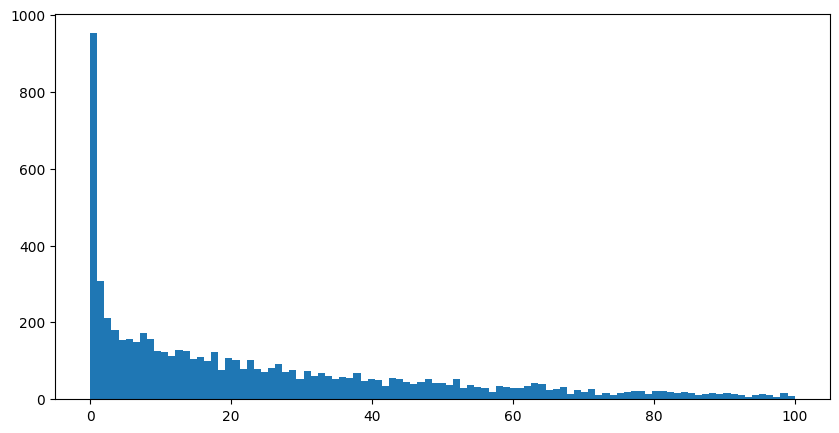

In [6]:
plt.hist(grb['T90'],bins= np.linspace(0,100,100));

That's useless. Let's plot the log. 

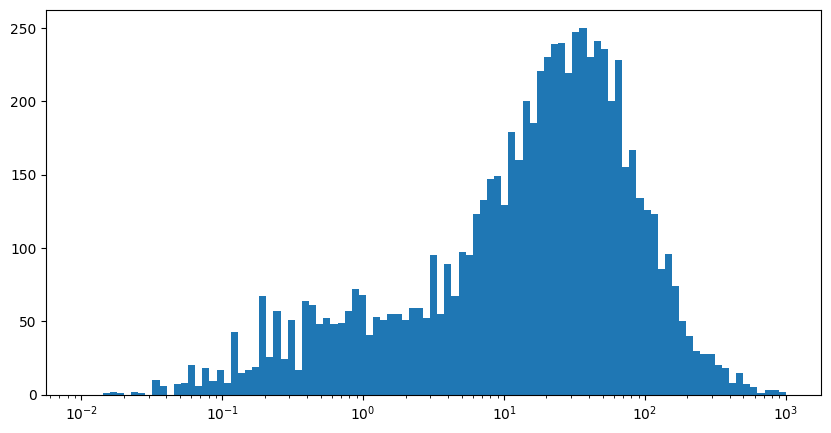

In [7]:
plt.hist(grb['T90'],bins= np.logspace(-2,3,100));
plt.semilogx();

Ok I like it. I know some physics and remember that people talk about long and short gamma-ray bursts all the time. Are there two modes there? Mmmmh, probably yes, but I don't trust those bins on the left... Let's try another density estimator just make sure things are ok

Actually, need some data cleaning first

In [8]:
# I want to fit the log of T90...
lT90 = np.log10(grb['T90'])
# Some cleaning...
lT90=lT90[~np.isnan(lT90)] 
# Reshape for scikit-learn
skT90 = lT90[:,np.newaxis]

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_22385/1245724041.py:2: RuntimeWarning: invalid value encountered in log10
  lT90 = np.log10(grb['T90'])


In [9]:
# Fit a KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.08).fit(skT90) #fit the model to the data

In [10]:
xgrid=np.logspace(-3,3,100)
# Rememember score_samples is the log-likelohood. Neep an exp in front
ygrid = np.exp(kde.score_samples(np.log10(xgrid)[:,np.newaxis]))

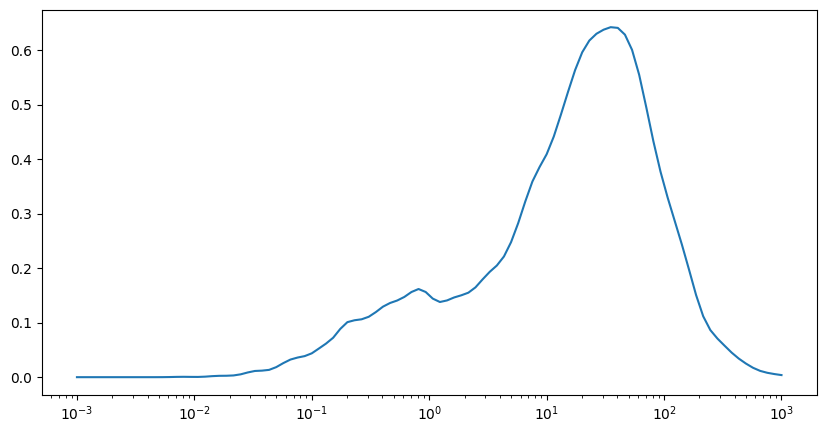

In [11]:
plt.plot(xgrid,ygrid)
plt.semilogx();

Yes those are definitely two modes. I haven't optimized the bandwith here. I could do it but I'm confident there are only two modes now.

Let's try to separate them in an unsupervised fashion

In [13]:
clf = KMeans(n_clusters=2, n_init='auto') #Try 2 clusters to start with
clf.fit(skT90)


KMeans(n_clusters=2, n_init='auto')

Smooth. Let's see where my clusters are centered

In [14]:
centers = clf.cluster_centers_ #location of the clusters
centers = 10**np.squeeze(centers)
centers #in seconds

array([32.88292941,  0.87614313])

And also let's label each point as belonging to the two classes



In [15]:
labels = clf.predict(skT90) #labels for each of the points

Make sure that the clusters are ordered. If they are not, swap the labels

In [16]:
if centers[0]>centers[1]:
    centers=centers[::-1] # Reverse array
    labels = np.array(~np.array(labels,dtype='bool'),dtype='int') # Swap 0 <--> 1

In [17]:
centers, labels

(array([ 0.87614313, 32.88292941]), array([1, 1, 1, ..., 0, 1, 0]))

It's Kmeans in 1D, so a cluster finishes when the other stars. The boundary is: 

In [18]:
edge = 10**( np.mean( [max(skT90[labels==0]), min(skT90[labels==1]) ]))

    
print(max(skT90[labels==0]), min(skT90[labels==1]), edge)



[0.72916479] [0.72997429] 5.364997670083372


Ok let's plot the center of the two clusters and the edge


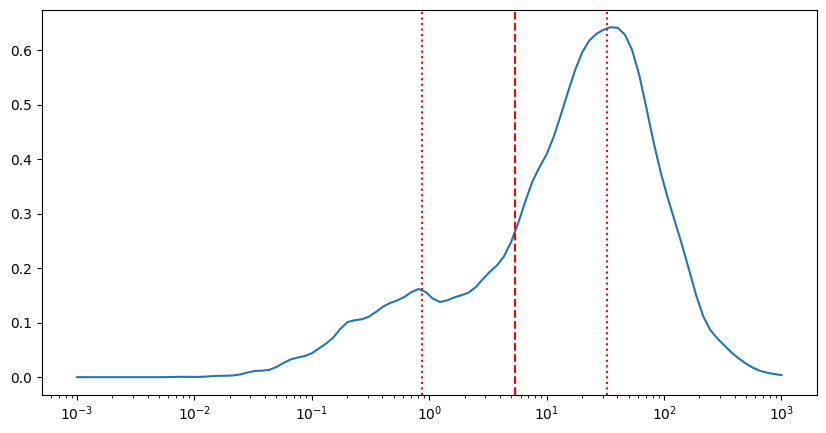

In [19]:

plt.plot(xgrid,ygrid)
plt.semilogx()
for v in centers:
    plt.axvline(v, c='red',ls='dotted')
plt.axvline(edge,c='red',ls='dashed')
    

To be honest, those blobs seem very Gaussian in log. Let's have a look at a Gaussian Mixture Model as well

In [20]:
gmm = GaussianMixture(2).fit(skT90)

All smooth. The gaussians are centered at

In [21]:
means = 10**np.squeeze(gmm.means_)

In [22]:
means

array([30.69331696,  0.93117999])

The pdf of each mode is

In [23]:
responsibilities = gmm.predict_proba(skT90)

Again make sure the modes are sorted:

In [24]:
if means[0]>means[1]:
    means=means[::-1]
    responsibilities= responsibilities[:,::-1]

In [25]:
means,responsibilities

(array([ 0.93117999, 30.69331696]),
 array([[8.27339145e-03, 9.91726609e-01],
        [6.66260995e-03, 9.93337390e-01],
        [1.33385477e-02, 9.86661452e-01],
        ...,
        [6.22401485e-01, 3.77598515e-01],
        [8.70366024e-04, 9.99129634e-01],
        [3.17307976e-01, 6.82692024e-01]]))

In [26]:
ygmm = np.exp(gmm.score_samples( np.log10(xgrid)[:,np.newaxis] ))

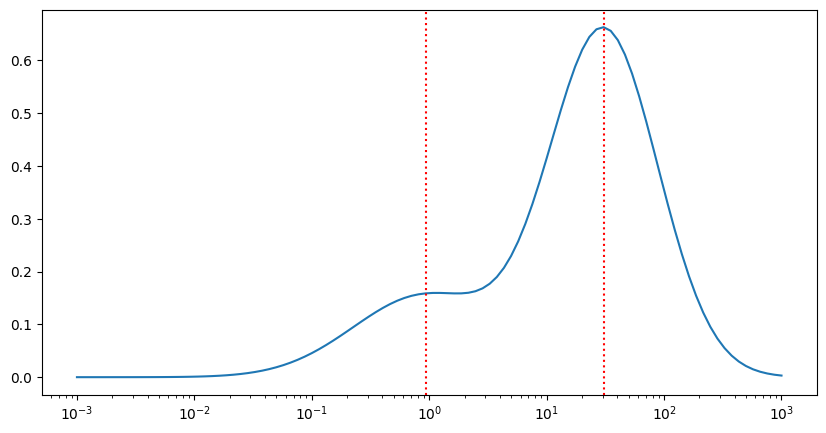

In [27]:
plt.plot(xgrid,ygmm)

for v in means:
    plt.axvline(v, c='red',ls='dotted')
    
plt.semilogx();

Which is a result that is very compatible with what I had before. Two methods giving the same results. Let's go! That's science!

Let's check the numbers for the cluster centers with the two approaches

In [28]:
for l,c,m in zip(['Short GRBs','Long GRBs'],np.sort(centers),np.sort(means)):
    print(l,": ", c,m, np.abs(c-m)/np.mean([c,m]) )

Short GRBs :  0.8761431260878707 0.9311799944776429 0.06090429294408747
Long GRBs :  32.88292940914907 30.69331696139259 0.06888146352632256


Good enough I'd say. For each datapoint now find the preferred gaussian mode:

In [29]:
gmmoutcome = np.array(responsibilities[:,0]<responsibilities[:,1],dtype='int')

In [30]:
gmmoutcome

array([1, 1, 1, ..., 0, 1, 1])

In [31]:
labels

array([1, 1, 1, ..., 0, 1, 0])

The number of observations that the GMM says are in row $i$ predicted by the clustering algorithm to be in column-$j$


In [32]:
confusion_matrix(gmmoutcome,labels)

array([[1607,    0],
       [ 246, 5501]])

In [33]:
shortbelow = np.array( [ np.sum( gmmoutcome[lT90<thr]==0)  for thr in np.log10(xgrid)] )
longbelow = np.array( [ np.sum( gmmoutcome[lT90<thr]==1)  for thr in np.log10(xgrid)] )

shortabove = np.array( [ np.sum( gmmoutcome[lT90>thr]==0)  for thr in np.log10(xgrid)] )
longabove = np.array( [ np.sum( gmmoutcome[lT90>thr]==1)  for thr in np.log10(xgrid)] )

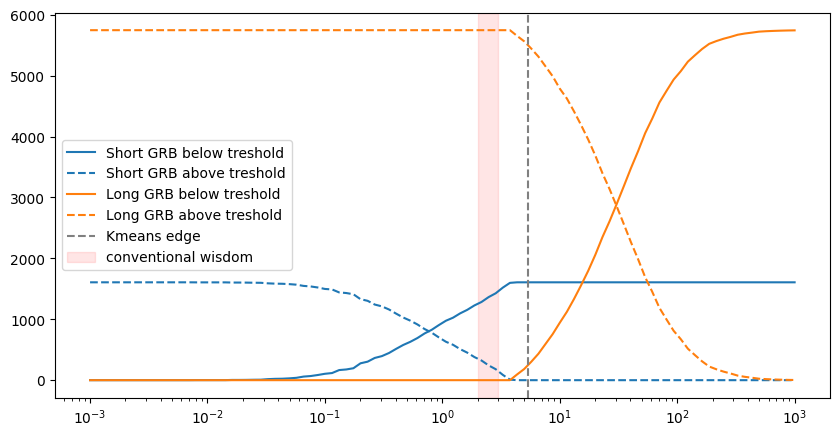

In [34]:
plt.plot(xgrid,shortbelow,label='Short GRB below treshold', c='C0',ls='solid')
plt.plot(xgrid,shortabove,label='Short GRB above treshold',c='C0',ls='dashed')
plt.plot(xgrid,longbelow,label='Long GRB below treshold',c='C1',ls='solid')
plt.plot(xgrid,longabove,label='Long GRB above treshold',c='C1',ls='dashed')
plt.semilogx()
plt.axvline(edge,c='gray',ls='dashed',label='Kmeans edge')

plt.axvspan(2,3,alpha=0.1,color='red',label='conventional wisdom')

plt.legend()

From scouting the scientific litterature on the topic, it looks like people quote a separation between short and long GRBs somewhere between 2 and 3 seconds. Which is ok, but our is actually closer to 5

In [35]:
edge

5.364997670083372

# Hang on... I've neglected the errors!

I just neglected all the measurment errors! Oh man, I'm a terrible statistician!

Some data cleaning first:

In [36]:
times = grb['T90'][~np.isnan(np.log10(grb['T90']))]
errortimes= grb['T90_error'][~np.isnan(np.log10(grb['T90']))]

times = times[errortimes>-10]
errortimes = errortimes[errortimes>-10]

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_22385/1425016.py:1: RuntimeWarning: invalid value encountered in log10
  times = grb['T90'][~np.isnan(np.log10(grb['T90']))]
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_22385/1425016.py:2: RuntimeWarning: invalid value encountered in log10
  errortimes= grb['T90_error'][~np.isnan(np.log10(grb['T90']))]


[]

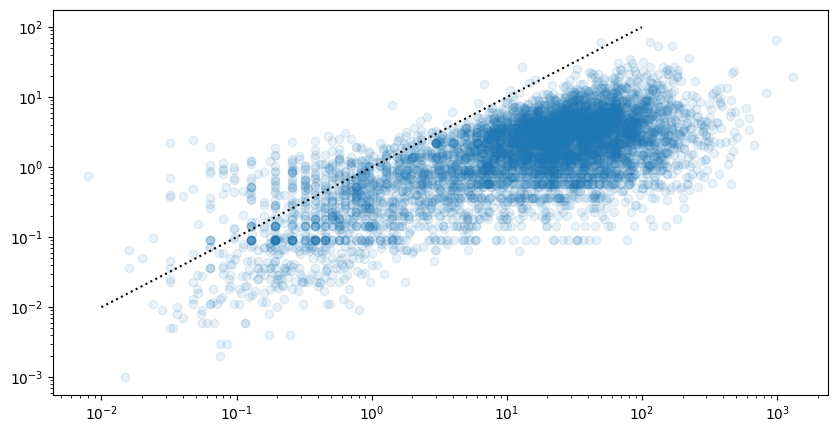

In [38]:
plt.scatter(times,errortimes,alpha=0.1)
plt.plot([1e-2,1e2],[1e-2,1e2],c='black',ls='dotted')
plt.loglog()


The errors on the individual measurements are typically smaller the typical width of the distribution. So I'm happy, what I've done above (i.e. neglecting errors entirely) does make sense.

This is not true for the low-t part of the sample. There might be a systematic bias there (which perhaps explains the difference in the cluster edge? Not sure). 

To relax this assumption, I could fit a correlated two-dimensional gaussian model with either MCMC or nested sampling.

## Redshifts

Can I do something interesting with the redshift data?

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_22385/1051128819.py:1: RuntimeWarning: invalid value encountered in log10
  plt.scatter(grb['T90'][~np.isnan(np.log10(grb['T90']))],grb['redshift'][~np.isnan(np.log10(grb['T90']))])


(0.0, 10.0)

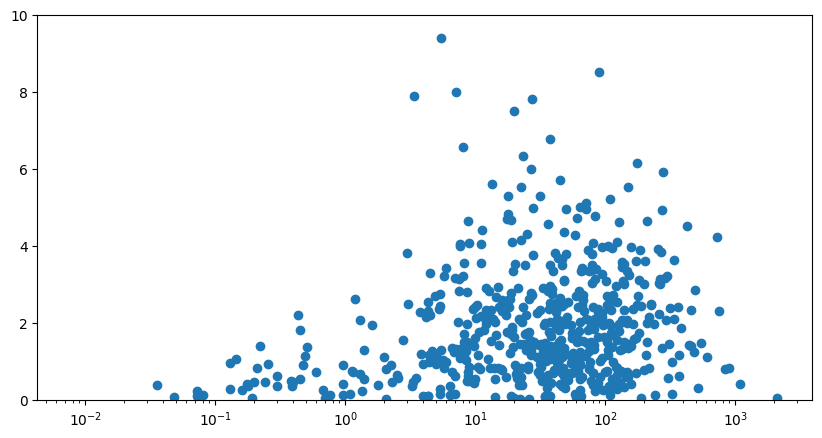

In [39]:
plt.scatter(grb['T90'][~np.isnan(np.log10(grb['T90']))],grb['redshift'][~np.isnan(np.log10(grb['T90']))])
plt.semilogx()
plt.ylim(0,10)

Looks like long GRBs are far and short GRBs are close. My physics background tells me this is right: long GRBs come from supernovae (young stars) while short  GRBS come from neutron-star mergers (old stars). 

But I don't understand/trust selection effects enough here. Redshift from short GRBs and much harder to get (need follow up in other bands!), so this might all be a selection bias.